EM27 Ratios
==============

## Import packages, define functions, and load data

### Imports and Global functions

In [31]:
#Import Packages
import pandas as pd
import numpy as np
import os
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import datetime
from matplotlib.colors import Normalize
from pylr2 import regress2
import sys
sys.path.append('..')
import funcs.ac_funcs as ac
pd.options.mode.chained_assignment = None
#Autoreload changed local modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
#Define some functions

def merge_oofdfs(oof_dfs,dropna=False):
    '''Function to merge oof dfs and add the instrument id as a suffix to each column name. Generally we use
    this when comparing two oof dfs, such as correcting one to another via an offset. 
    
    Args: 
    oof_dfs (dict): dictionary of oof dataframes, where the key is the instrument id (like 'ha') and the value is the dataframe
    dropna (bool): True if we want to drop na values (when joining, often there are many), False if not. Default False
    
    Returns:
    merged_df (pd.DataFrame): pandas dataframe of the merged oof dfs, with suffixes for instrument id added to each column
    '''

    inst_ids = oof_dfs.keys() #get the instrument ids
    dfs_for_merge = {} #initialize the dataframes for merging
    for inst_id in inst_ids: #loop through the instrument ids
        df = oof_dfs[inst_id].copy() #copy the dataframe for that instrument id
        for col in df.columns: #for each of the columns in the dataframe
            df = df.rename(columns={col:f'{col}_{inst_id}'}) #add the instrument id as a suffix to the original column name after a _
        dfs_for_merge[inst_id] = df #add this dataframe to the merge dict
    merged_df = pd.DataFrame() #initialize the merged dataframe
    for inst_id in inst_ids: #for all of the dataframes
        merged_df = pd.concat([merged_df,dfs_for_merge[inst_id]],axis = 1) #merge them into one by concatenating
    if dropna: #if we want to drop the na values,
        merged_df = merged_df.dropna() #do it
    return merged_df

def get_regression(df,x_spec,y_spec):
    '''Does a type II linear regression and returns the relevant details as a dictionary
    
    Args:
    df (pd.DataFrame) : pandas dataframe containing the data on which we want to do the regression
    x_spec (str) : name of the column in the df that is the "x" data for the regression
    y_spec (str) : name of the column in the df that is the "y" data for the regression
    
    Returns:
    reg_details (dict) : a dictionary containing details of the regression, including x and y lines, slope, intercept, and r2
    '''

    regression = regress2(df[x_spec],df[y_spec]) #run the regression 
    x_regr_line = np.linspace(df[x_spec].min(),df[x_spec].max(),10) #create the x line from min to max
    y_regr_line = x_regr_line * regression['slope'] + regression['intercept']  #create the y regression line using the x min to max values
    reg_details = dict(lm = regression,
               x_regr_line = x_regr_line,
               y_regr_line = y_regr_line,
               slope = regression['slope'],
               yint = regression['intercept'],
               r2 = regression['r']**2) #create the details 
    return reg_details 

def plot_reg_on_ax(ax,reg_details,labsize = 10,color = 'grey'):
    '''Plots a regression line and its details on a matplotlib ax and legend
    
    Args:
    ax (axis from plt): a plt ax object on which to plot
    reg_details (dict) : details of the regression, generated by get_regression()
    labsize (int) : size of the label for the legend
    
    Returns:
    ax : plt ax object with the regression line and legend plotted
    '''
    
    annotation = f"R2={reg_details['r2']:.2}\nslope={reg_details['slope']:.2}\ny_interc={reg_details['yint']:.2}"
    ax.plot(reg_details['x_regr_line'],reg_details['y_regr_line'],label = annotation,c = color)
    ax.legend(fontsize = labsize)
    return ax

In [20]:
#The base project directory, which should contain a "Data" folder and the Atmos_Column git repo
base_project_dir = '/uufs/chpc.utah.edu/common/home/u0890904/LAIR_1/'
figures_path = os.path.join(base_project_dir,'Figures','ratios_ipynb')

### Load and correct EM27 oof datasets to one another. 
This should only need to be done once, then can be stored as pickle files for fast loading in the future

In [ ]:
#Load the side by side data for ua and ha so that we can correct to one another
inst_details = {'ha':os.path.join(base_project_dir,'Data/EM27_oof/SLC_EM27_ha_2022_2023_oof_v2_nasrin_correct'),
                'ua':os.path.join(base_project_dir,'Data/EM27_oof/summer_2023/elaine_retrievals/ua')}
filter_flag_0 = True #set to True if we want to filter bad spectra
resample = 'T' #this will resample to that level -- needed to merge dfs and do the regression (and thereby correction)
timezone = 'US/Mountain'  #timezone within which to load the dataframes
specs = ['xch4(ppm)','xco2(ppm)','xco(ppb)'] #these are the species we want to correct

#the datetime string ranges below are the ranges when the ua EM27 and ha EM27 were side by side on the roof of wbb
dt_str_ranges = [{'start':'2023-07-08 11:00:00','end':'2023-07-11 23:59:59'},
                 {'start':'2023-08-13 00:00:00','end':'2023-08-14 23:59:59'}]
my_oof_managers = {} #initialize a dictionary of oof managers for loading data
oof_dfs = {} #intialize a dictionary of oof dataframes to store the loaded dta
for inst_id in inst_details.keys(): #load each oof dataframe
    oof_dfs[inst_id] = pd.DataFrame() #initialize it
    for dt_str_range in dt_str_ranges: #go through each datetime range
        dt1 = ac.dtstr_to_dttz(dt_str_range['start'],timezone) #get the start and end of the range
        dt2 = ac.dtstr_to_dttz(dt_str_range['end'],timezone)
        data_folder = inst_details[inst_id] #the data folder is defined in the instrument details dicitonary
        my_oof_managers[inst_id] = ac.oof_manager(data_folder,timezone) #create the oof manager for that instrument
        df = my_oof_managers[inst_id].load_oof_df_inrange(dt1,dt2,filter_flag_0=filter_flag_0,cols_to_load=specs) #load the datetime in the range
        if resample is not None: #if there is a resample value
            df = df.resample(resample).mean(numeric_only = True) #resample to that value by mean
        oof_dfs[inst_id] = pd.concat([oof_dfs[inst_id],df]) #concatenate the dataframe with the other ones for that inst id (other datetime ranges)
merged_df = merge_oofdfs(oof_dfs,dropna=True) #merge the dataframes into a single dataframe so that we can do the regression, and drop na values. 

In [ ]:
#Correct the UA data to the HA data using a simple regression

#Get the regressions for each species of interest
correction_regressions = {'direction':['ua','ha']} #the direction indicates which instrument (first element) is being corrected "to" the other instrument (second element)
for spec in specs: #for all of the species
    x_inst = correction_regressions['direction'][0] #the direction **from** which we are correcting
    y_inst = correction_regressions['direction'][1] #the direction **to** which we are correcting 
    x_spec = f'{spec}_{x_inst}' #the merged dataframes have column names which have _{inst_id} trailing each element of the normal oof column names. specify using the directions above
    y_spec = f'{spec}_{y_inst}'
    reg_details = get_regression(merged_df,x_spec,y_spec) #do the regression
    correction_regressions[spec] = reg_details #get the details for each species and store in a dictionary

In [ ]:
#Now load the entire dataset and correct using the appropriate regressions created above

resample = None #don't resample as we will do plenty of that with the sza stuff later

#the full dataset as of now is between the below dates
dt1_str = '2022-05-08 00:00:00'
dt2_str = '2023-12-01 00:00:00' 
dt1 = ac.dtstr_to_dttz(dt1_str,timezone)
dt2 = ac.dtstr_to_dttz(dt2_str,timezone)

#Load much like above
my_oof_managers = {}
oof_dfs = {}
for inst_id,path in inst_details.items():
    data_folder = os.path.join(base_project_dir,path)
    my_oof_managers[inst_id] = ac.oof_manager(data_folder,timezone)
    df = my_oof_managers[inst_id].load_oof_df_inrange(dt1,dt2,filter_flag_0=filter_flag_0)
    if resample is not None:
        df = df.resample(resample).mean(numeric_only = True)
    if inst_id == 'ua': # ** There are some data in the ua data folder from a TCCON side by side in may of 2023. Utah data doesn't start until july, so filter be fore that
        df = df.loc[df.index>'2023-07-01']
    oof_dfs[inst_id] = df.dropna(how='all') #drop rows that are all na from the resample

#Actually correct the dataframes using the correctin regressions
for inst_id, oof_df in oof_dfs.items(): #loop through the instrument ids 
    if inst_id == correction_regressions['direction'][0]: #depending on the direction: if it's the first instrument id, we're correcting to the second
        for spec in specs: #for each of the species
            oof_df[f'corr_{spec}'] = oof_df.apply(lambda row: row[spec]*correction_regressions[spec]['slope']+correction_regressions[spec]['yint'] ,axis = 1) #actually move the data using the regression details
    elif inst_id == correction_regressions['direction'][1]:#if it's the one we're correcting TO:
        for spec in specs:
            oof_df[f'corr_{spec}'] = oof_df[spec] #just rename it so we're consistent -- the values do not change
    else:
        raise Exception('something wrong here')

In [ ]:
# Sanity Check -- look at side-by-side data in corrected sets to be sure they line up as expected

#Create plot dataframes during times of side by side data
dt_str_ranges = [{'start':'2023-07-08 11:00:00','end':'2023-07-11 23:59:59'},
                 {'start':'2023-08-13 00:00:00','end':'2023-08-14 23:59:59'}]
plot_dfs = {}
for inst_id, oof_df in oof_dfs.items():
    plot_df = pd.DataFrame()
    for dt_str_range in dt_str_ranges:
        sub_df = oof_df.loc[ (oof_df.index >= dt_str_range['start'])&
                             (oof_df.index <= dt_str_range['end']) ]
        plot_df = pd.concat([plot_df,sub_df])
    plot_dfs[inst_id] = plot_df

#plot the corrected species between the instruments for comparison
plot_specs = ['corr_xco2(ppm)','corr_xch4(ppm)','corr_xco(ppb)']
colors = {'ua':'red','ha':'blue'}
fig = make_subplots(3,1,shared_xaxes=True)
for row in range(1,4):
    plot_spec = plot_specs[row-1]
    leg = True if row == 1 else False
    for inst_id, plot_df in plot_dfs.items():
        fig.add_trace(go.Scatter(
            x = plot_df.index,
            y = plot_df[plot_spec],
            mode = 'markers',
            marker_color = colors[inst_id],
            marker_size = 3,
            name = inst_id,
            showlegend=leg
        ),row = row, col = 1)
        fig.update_yaxes(title_text=plot_spec, row=row, col=1)
fig.update_layout(
    height = 700
)
fig.show()

In [ ]:
# Send each full dataframe to a pickle file so we can load them quickly later
pickle_folder = os.path.join(base_project_dir,'Data','Pickled_files','corrected_em27_dfs')
for inst_id, oof_df in oof_dfs.items():
    fname = f'{inst_id}_corr_flag0.pkl'
    oof_df.to_pickle(os.path.join(pickle_folder,fname))

### Load EM27 datasets from pickle (as created above)

In [8]:
#Load the EM27 datasets from pickle files
pickle_folder = os.path.join(base_project_dir,'Data','Pickled_files','corrected_em27_dfs')  #this is where the pickle files live
oof_dfs = {} #initialize the oof_dfs dictionary which will store the bibg dtaframes
for file in os.listdir(pickle_folder): #loop through each of the files in the flolder
    inst_id = file.split('_')[0] #the instrument id should be the first element before the _ in the filename (ha or ua most likely)
    oof_dfs[inst_id] = pd.read_pickle(os.path.join(pickle_folder,file)) #read it in and store in the oof dictionary

keep_cols = ['flag','solzen(deg)','corr_xco(ppb)','xco(ppb)_error','corr_xch4(ppm)','xch4(ppm)_error','corr_xco2(ppm)','xco2(ppm)_error'] #pare down the dfs to just these cols
for inst_id in oof_dfs.keys(): #do some extra operations if we want to...
    oof_dfs[inst_id] = oof_dfs[inst_id][keep_cols]
    oof_dfs[inst_id]['corr_xco(ppm)'] = oof_dfs[inst_id]['corr_xco(ppb)']/1000 #create a CO column in PPM instead of PPB for easier ratio comparisons

    # Below is often commented out. I was trying to make the anomaly calculation faster by resampling the oof_dfs before doing any operations, 
    # but that didn't seem to make a big difference. Still can make faster
    #oof_dfs[inst_id] = oof_dfs[inst_id].resample('T').mean(numeric_only = True)
    #oof_dfs[inst_id] = oof_dfs[inst_id].dropna(how = 'all')

In [ ]:
# Sanity Check -- look at side-by-side data in corrected sets to be sure they line up as expected

#Create plot dataframes during times of side by side data
dt_str_ranges = [{'start':'2023-07-07 11:00:00','end':'2023-07-11 23:59:59'},
                 {'start':'2023-08-13 00:00:00','end':'2023-08-14 23:59:59'}]
plot_dfs = {} #these are the plot dataframes only containing data from the side by side periods
for inst_id, oof_df in oof_dfs.items(): 
    plot_df = pd.DataFrame()
    for dt_str_range in dt_str_ranges:
        sub_df = oof_df.loc[ (oof_df.index >= dt_str_range['start'])&
                             (oof_df.index <= dt_str_range['end']) ]
        plot_df = pd.concat([plot_df,sub_df])
    plot_dfs[inst_id] = plot_df

#plot the corrected species between the instruments for comparison
plot_specs = ['corr_xco2(ppm)','corr_xch4(ppm)','corr_xco(ppm)']
colors = {'ua':'red','ha':'blue'}
fig = make_subplots(3,1,shared_xaxes=True)
for row in range(1,4):
    plot_spec = plot_specs[row-1]
    leg = True if row == 1 else False
    for inst_id, plot_df in plot_dfs.items():
        fig.add_trace(go.Scatter(
            x = plot_df.index,
            y = plot_df[plot_spec],
            mode = 'markers',
            marker_color = colors[inst_id],
            marker_size = 3,
            name = inst_id,
            showlegend=leg
        ),row = row, col = 1)
        fig.update_yaxes(title_text=plot_spec, row=row, col=1)
fig.update_layout(
    height = 700
)
fig.show()

### Separate into days, add a rise and set column

In [9]:
#This separates the oof_dfs into daily dataframes and adds a rise and set column to them. This is helpful because each "day" of data
#is how we calculate the daily anomolies, etc. The result is a dictionary called day_separated_dfs, where each element is one of the instruments
#Within this instrument day_separated_df, there is another dictionary where the keys are strings representing the date and the value is the 
#dataframe of data for that date. 

day_separated_dfs = {}
for inst_id, oof_df in oof_dfs.items():
    #Split into daily, add rise and set column
    daily_dfs = [part for _, part in oof_df.groupby(pd.Grouper(freq='1D')) if not part.empty] #parse into a list of daily dataframes
    for df in daily_dfs: #for each daily dataframe
        min_sza_idx = df['solzen(deg)'].idxmin() #find the sun's peak (min sza)
        df['rise_set'] = ['rise' if idx <= min_sza_idx else 'set' for idx in df.index] #add a column indicating if the sun is rising or setting (before or after peak)
    day_separated_dfs[inst_id] = {df.index[0].strftime('%Y-%m-%d'): df for df in daily_dfs} #create a dictionary where the keys are date strings and value for each is a dataframe for that day

In [10]:
# Creates a summary of the daily data
summary_dfs = {}
for inst_id,daily_dicts in day_separated_dfs.items():
    summary_dicts = [] #place to store the summary values to create the dataframe
    for df in daily_dicts.values(): #loop through all of the daily dataframes
        date = df.index[0].date() #the dates should all be the same (it's a daily dataframe after all) so just choose the first one
        good_rows = len(df) #how many good rows there are
        min_time = df.index.min().time() #the time of first good row
        max_time = df.index.max().time() #the time of the last good row
        try: #try to get the first sza during rise
            rise_sza_max = df.loc[df['rise_set']=='rise']['solzen(deg)'].max()
        except: #if not (no rise, started after peak) just make it nan
            rise_sza_max = np.nan
        try: #try to get the last sza during set
            set_sza_max = df.loc[df['rise_set']=='set']['solzen(deg)'].max()
        except: #if not (no set, ended before peak) just make it nan
            set_sza_max = np.nan
        summary_dicts.append(dict(date = date,
                                good_rows = good_rows,
                                min_time = min_time,
                                max_time = max_time,
                                rise_sza_max = rise_sza_max,
                                set_sza_max = set_sza_max)) #append all the summary variables
    summary_df = pd.DataFrame(summary_dicts) #make the list of dicts into a dataframe
    summary_dfs[inst_id] = summary_df

#Can be nice to look at this to see what data exists:
#summary_dfs['ha']

# Create Ratio Datasets

## Wunch 2009 Anomaly Method
This method for comparing EM27 ratios comes from https://doi.org/10.1029/2009GL039825. It bins data into separate solar zenith angles (sza) and subtracts the 'sun rising' concentration values in each sza bin from the 'sun setting' concentration values in the corresponding sza bin. 

In [11]:
def create_binned_summary(df,sza_bin_size,spec_names):
    '''Creates a summary dataframe for binning values on sza for rising and setting sun. Used for getting "daily anomolies" per Wunch 2009
    
    Args:
    df (pd.DataFrame): pandas dataframe containing EM27 data
    sza_bin_size (int, float): size (in degrees) to make the solar zenith angle bins
    spec_names (list): list of strings corresponding to the species wanted. takes the mean of each species for the corresponding "rise" or "set for the sza bin
    
    Returns:
    binned_summary_df (pd.DataFrame): dataframe containing information about the sza binned data'''
    bins = np.arange(0,90,sza_bin_size) #create the bins
    df['sza_bin'] = pd.cut(df['solzen(deg)'],bins) #create a column in the dataframe indicating the bin that row belongs to
    grouped = df.groupby(['sza_bin','rise_set']) #group by the bin as well as rise_set so that they are two separate entities
    binned_summary = [] #initialize a list to store summary data
    for name, group in grouped:
        bin_dict = {} #initialize the binned group's data dict
        bin_dict['tstart'] = group.index[0] #start time of the bin
        bin_dict['tend'] = group.index[-1] #end time of the bin
        bin_dict['tmid'] = bin_dict['tstart']+(bin_dict['tend']-bin_dict['tstart'])/2 #middle time of the bin (can be used for plotting)
        bin_dict['sza_bin'] = name[0] #the sza bin itself
        bin_dict['nobs'] = len(group) #how many observations in that bin
        spec_bin_means = group.mean(numeric_only=True)[spec_names] #get the means of the species we want
        bin_dict.update({col:spec_bin_means[col] for col in spec_names}) #add the means to the bin_dict
        bin_dict['rise_set'] = name[1] #whether it is 'rise' or 'set'
        binned_summary.append(bin_dict) #append that group's info to the summary list
    binned_summary_df = pd.DataFrame(binned_summary)  #make the dataframe from the list of dicts
    binned_summary_df['sza_mid'] = binned_summary_df.apply(lambda row:row['sza_bin'].mid,axis = 1)
    return binned_summary_df

def daily_anomaly_creator(binned_summary_df,spec_names):
    '''Create the daily anomoly
    
    Args:
    binned_summary_df (pd.DataFrame): created using create_binned_summary, contains daily summary information
    spec_names (list): list of the species names to use
    
    Returns:
    anom_df (pd.DataFrame): dataframe of the daily anomolies
    skipped_df (pd.DataFrame): dataframe containing information about bins that were skipped and why
    '''

    bin_grouped = binned_summary_df.groupby('sza_bin') #group by sza bin
    #initialize the data lists
    anom_list = []
    skipped_list = []
    for name,group in bin_grouped:
        if len(group)>2: #make sure there's not more than two rows -- should just be one rise and one set for that sza bin
            raise Exception('grouped df greater than 2 -- investigate') 
        if not all(item in group['rise_set'].values for item in ['rise', 'set']): #check that exactly one rise and one set rows exist in the df
            skipped_list.append(dict(skipmode = 'no_match_sza', #document if so
                                        sza_bin = name,
                                        rise_set = group['rise_set'].unique()))
            continue #if there aren't a rise and set, we can't do the anomoly, so just go to the next grouping
        if (group['nobs'].max()>(2*group['nobs'].min())): #check that there aren't more that 2x the number of observations for "rise" compared to set (or vice versa)
            skipped_list.append(dict(skipmode = 'nobs',
                                        sza_bin = name)) #ifso, document and continue
            continue
        rise_row = group.loc[group['rise_set']=='rise'].squeeze() #get the rise data (squeeze gets the value)
        set_row = group.loc[group['rise_set']=='set'].squeeze() #same with set
        anom_dict = {f'{col}_anom':(set_row[col] - rise_row[col]) for col in spec_names} #subtract rise from set for that sza, for each species in the list
        anom_dict.update({'sza_bin':name}) #update the dict with the sza bin
        anom_list.append(anom_dict) #append it to the list
        
    anom_df = pd.DataFrame(anom_list) #create the dataframe for the anomolies
    if len(anom_df) > 0: #if there are entries in the anom df, add a sza midpoint for plotting
        anom_df['sza_mid'] = anom_df.apply(lambda row: row['sza_bin'].mid,axis = 1)
    skipped_df = pd.DataFrame(skipped_list) #create the dataframe for why some sza's may have been skipped
    return anom_df, skipped_df

In [12]:
# This creates all of the anomaly dataframes, for each instrument across the entire dataset
# Once run, we have a dictionary called all_anom_dfs, keys are inst_ids and values are all_anom_df dataframes
# Each dataframe has the anomalies along with the date that they came from and the sza angles they correspond to 
# This is pretty slow, even with 1 degree size bins. Could definitely speed this up. 

sza_bin_size = 1
spec_names = ['corr_xco2(ppm)','corr_xch4(ppm)','corr_xco(ppm)']

all_anom_dfs = {} #place to store each instrument's anomaly dataframe
all_skipped_dfs = {} #place to store each instrument's skipped details dataframe (why were anomalies skipped)
for inst_id,inst_daily_dfs in day_separated_dfs.items(): #loop through the day_separated dfs, as anomalies are built daily
    all_anom_df = pd.DataFrame() #initialize the anomaly dataframe
    all_skipped_df = pd.DataFrame()  #initialize the skipped details dataframe
    for date_str, df in inst_daily_dfs.items(): #for each day in the set of daily dataframes
        date = datetime.datetime.strptime(date_str,'%Y-%m-%d').date() #get the date
        binned_summary_df = create_binned_summary(df,sza_bin_size,spec_names) #create the binned summary
        day_anom_df, day_skipped_df = daily_anomaly_creator(binned_summary_df,spec_names) #create that day's anomaly and skipped details dataframes
        day_anom_df['date'] = date #add date columns to each of the dataframes
        day_skipped_df['date'] = date
        all_anom_df = pd.concat([all_anom_df,day_anom_df]) #concat with the previous date's dataframes
        all_skipped_df = pd.concat([all_skipped_df,day_skipped_df])
    all_anom_df = all_anom_df.reset_index(drop=True) #reset the indicies for better viewing
    all_skipped_df = all_skipped_df.reset_index(drop = True)
    all_anom_dfs[inst_id] = all_anom_df #add the concatenated dataframes to each instrument's place in the original dictionary 
    all_skipped_dfs[inst_id] = all_skipped_df

### Anomaly Illustration: Single Day

In [61]:
#Define an instrument, date, sza bin size, and the species we want 
inst_id = 'ha'
date_str = '2022-10-19'
sza_bin_size = 1
spec_names = ['corr_xco2(ppm)','corr_xch4(ppm)','corr_xco(ppm)']

day_df = day_separated_dfs[inst_id][date_str].copy()  #get the specific day's df for that instrument
binned_summary_df = create_binned_summary(day_df,sza_bin_size,spec_names) #create the binned summary 
anom_df, skipped_df = daily_anomaly_creator(binned_summary_df,spec_names) #get the anomaly and skipped rows dataframes 

In [70]:
#Create a timeseries plot showing each species of interest and the idea behind the SZA binning/anomaly calculation.

#Setup the fig
fig, axs = plt.subplots(4, 1, figsize=(15, 9))
labsize = 15
fig.suptitle('EM27 Single Day Anomaly Illustration', fontsize=24)
fname = 'em27_singleday_anomaly_ts.png'

# Get the min and max 'solzen(deg)' values in the DataFrame 'df'
min_sza = day_df['solzen(deg)'].min()
max_sza = day_df['solzen(deg)'].max()
# Create a ScalarMappable object for color mapping
cmap = 'plasma_r'#'autumn_r'
norm = Normalize(vmin=min_sza, vmax=max_sza)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # To satisfy ScalarMappable

min_sza_idx = day_df['solzen(deg)'].idxmin() #for drawing the vertical line indicating change from "rise" to "set"

#The first three rows are timeseries of the species of interest
for row in range(0, 3): 
    spec = spec_names[row] #get the species
    axs[row].scatter(
        day_df.index,
        day_df[spec],
        s=3,
        c='grey',
        alpha=0.8,
        label='Collected Data'
    ) #plot the raw data in grey 
    scatter = axs[row].scatter(
        binned_summary_df['tmid'],
        binned_summary_df[spec],
        s=80,
        edgecolors = 'k',
        c=binned_summary_df['sza_mid'],
        cmap=cmap,
        norm=norm,  # Apply the same normalization to ensure consistent color scale
    )#plot the sza binned data, and color by like sza bins
    axs[row].tick_params(labelsize=labsize)
    axs[row].set_ylabel(spec, size=labsize)
    axs[row].spines['top'].set_visible(False)
    axs[row].spines['right'].set_visible(False)
    axs[row].axvline(min_sza_idx, c='grey', alpha=0.5)

# Adjusting the last subplot for 'solzen(deg)' visualization
row = 3
axs[row].scatter(
    day_df.index,
    day_df['solzen(deg)'],
    s=50,
    c=day_df['solzen(deg)'],
    cmap=cmap,
    norm=norm  # Apply the same normalization to ensure consistent color scale
)
axs[row].axvline(min_sza_idx, c='grey', alpha=0.5) #vertical line for showing change from 'rise' to 'set'
axs[row].tick_params(labelsize=labsize)
axs[row].set_ylabel('SZA ($^\circ$)', size=labsize)
axs[row].spines['top'].set_visible(False)
axs[row].spines['right'].set_visible(False)
axs[row].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M', tz=day_df.index.tz))
axs[row].set_xlabel(datetime.datetime.strftime(df.index[0], '%Y-%m-%d %Z'), size=labsize)

# Adjusting layout and formatting
plt.subplots_adjust(hspace=0.1)
plt.gcf().autofmt_xdate()
plt.tight_layout()
ts_fname = os.path.join(figures_path,fname)
plt.savefig(ts_fname,dpi=300)
plt.close()
#plt.show()

In [73]:
# Ratio plot, showing comparisons of anomalies as in Figure 2 of Wunch 2009

#Setup the figure
fig,axs = plt.subplots(2,2,figsize = (7.5,7.5))
labsize = 12
markersize = 60
#fig.suptitle('Single Day Anomaly Compairsons',fontsize = 16)
fname = 'em27_singleday_anomoly_ratio.png'

#Create a quick function to make the scatter and regression subplot
def single_regression_subplot(ax,plot_df,x_spec,y_spec,markersize,cmap,norm,labsize):
    ax.scatter(plot_df[x_spec],
               plot_df[y_spec],
               c=plot_df['sza_mid'],
               cmap = cmap,
               norm = norm,
               s = markersize)
    reg_details = get_regression(plot_df,x_spec,y_spec)
    plot_reg_on_ax(ax,reg_details,labsize)
    ax.set_xlabel(x_spec,size = labsize)
    ax.set_ylabel(y_spec,size = labsize)
    ax.tick_params(labelsize = labsize)
    return ax

ax = axs[0,0] #top left
x_spec = 'corr_xco2(ppm)_anom'
y_spec = 'corr_xco(ppm)_anom'
single_regression_subplot(ax,anom_df,x_spec,y_spec,markersize,cmap,norm,labsize)

ax = axs[0,1] #top right
x_spec = 'corr_xco2(ppm)_anom' 
y_spec = 'corr_xch4(ppm)_anom'
single_regression_subplot(ax,anom_df,x_spec,y_spec,markersize,cmap,norm,labsize)

ax = axs[1,1] #bottom right
x_spec = 'corr_xco(ppm)_anom'
y_spec = 'corr_xch4(ppm)_anom'
single_regression_subplot(ax,anom_df,x_spec,y_spec,markersize,cmap,norm,labsize)

#The bottom left is used as a place to put some of the details, including how many "good anomaly" values there are and why the "bad anomaly" values
# were skipped
axs[1,0].axis('off')
text = f"DETAILS:\n\
Date: {datetime.datetime.strftime(day_df.index[0],'%Y-%m-%d')}\n\
SZA Bin: {sza_bin_size}$^\circ$\n\
Good Anomalies: {len(anom_df)}\n\
No matching SZA: {len(skipped_df.loc[skipped_df['skipmode']=='no_match_sza'])}\n\
Not enough obs: {len(skipped_df.loc[skipped_df['skipmode']=='nobs'])}"
axs[1,0].text(0.02,0.995,text,ha='left',va='top',fontsize = labsize*1.1)

# # Creating the colorbar
# cbar_ax = fig.add_axes([0.92, 0.3, 0.02, 0.4])  # Adjust position and size of colorbar
# cbar = plt.colorbar(sm, cax=cbar_ax)
# cbar.set_label('SZA ($^\circ$)', fontsize=labsize)

plt.subplots_adjust(hspace=0.35,wspace = 0.35)
plt.tight_layout()
ratio_fname = os.path.join(figures_path,fname)
plt.savefig(ratio_fname,dpi=300)
plt.close()

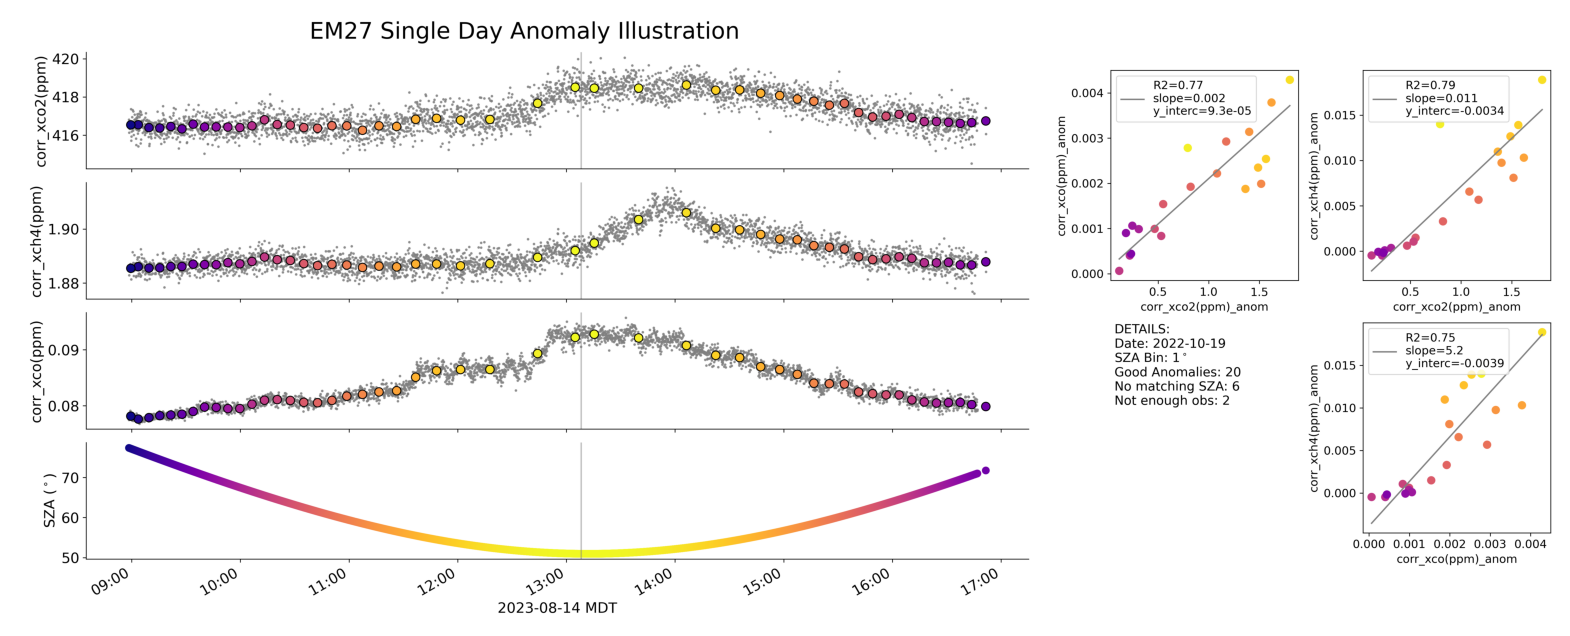

In [75]:
#Display the above plots side by side
fig = plt.figure(figsize = (20,10))
gs = gridspec.GridSpec(1,2,width_ratios=[2,1])

ax1 = plt.subplot(gs[0])
ax1.imshow(plt.imread(ts_fname))
ax1.axis('off')

ax2 = plt.subplot(gs[1])
ax2.imshow(plt.imread(ratio_fname))
ax2.axis('off')

plt.subplots_adjust(wspace=0.01)  # Adjust the wspace value as needed

plt.show()

## Daily Excess Using Concentration Quantiles

In [76]:
def resample_and_get_excess(df,resample,col_list,quantile):
    out_df = df.copy()
    out_df = resample_df(out_df,resample)
    out_df = subtract_quantile(out_df,col_list,quantile)
    return out_df

def subtract_quantile(df,col_list,quantile):
    for col in col_list:
        df[quant_col_label(col,quantile)] = df[col] - get_col_quantile(df,col,quantile)
    return df

def quant_col_label(col,quantile):
    return f'{col}_ex{int(quantile*100)}q'

def get_col_quantile(df,col,quantile):
    return df[col].quantile(quantile)

def resample_df(df,resample):
    return df.resample(resample).mean(numeric_only = True).dropna(how='all')

def rmv_prep(str):
    return '_'.join(str.split('_')[1:])

In [77]:
# This creates all of the quantile dataframes, for each instrument across the entire dataset
# Once run, we have a dictionary called all_quantile_dfs, keys are inst_ids and values are all_quantile_df dataframes
# Each dataframe has the quantile subtracted concentration values along with the date that they came from 

resample = '5T'
quantile = 0.01
col_list = ['corr_xco2(ppm)','corr_xch4(ppm)','corr_xco(ppm)']

all_quantile_dfs = {} #place to store each instrument's quantile
for inst_id,inst_daily_dfs in day_separated_dfs.items(): #loop through the day_separated dfs, as quantile backgrounds are built daily
    all_quantile_df = pd.DataFrame() #initialize the quantile dataframe
    for date_str, df in inst_daily_dfs.items(): #for each day in the set of daily dataframes
        day_df = resample_and_get_excess(df,resample,col_list,quantile)
        day_df['hour_of_day'] = day_df.index.hour
        date = datetime.datetime.strptime(date_str,'%Y-%m-%d').date() #get the date
        day_df['date'] = date #add date columns to each of the dataframes
        all_quantile_df = pd.concat([all_quantile_df,day_df]) #concat with the previous date's dataframes
    all_quantile_df = all_quantile_df.reset_index(drop=True) #reset the indicies for better viewing
    all_quantile_dfs[inst_id] = all_quantile_df #add the concatenated dataframes to each instrument's place in the original dictionary 

### Quantile Method: Single Day

In [78]:
resample = '5T'
quantile = 0.01

inst_id = 'ha'
date_str = '2022-10-19'
col_list = ['corr_xco2(ppm)','corr_xch4(ppm)','corr_xco(ppm)']
day_df = day_separated_dfs[inst_id][date_str].copy()
day_df = resample_and_get_excess(day_df,resample,col_list,quantile)
day_df['hour_of_day'] = day_df.index.hour

In [86]:
#Create a timeseries plot showing each species of interest and the idea behind quantile backgroudn calculation
specs = ['corr_xco2(ppm)','corr_xch4(ppm)','corr_xco(ppm)']

#Setup the fig
fig, axs = plt.subplots(3, 1, figsize=(15, 9))
labsize = 15
markersize = 30
fig.suptitle('EM27 Daily Excess (Quantile) Illustration', fontsize=24)
fname = 'em27_singleday_quantile_ts.png'

axs2 = []
for row in range(0,3):
    spec = specs[row] #get the species
    q_val = get_col_quantile(day_df,spec,quantile)
    axs[row].scatter(
        day_df.index,
        day_df[spec],
        s=markersize,
        c='grey',
        #alpha=0.8,
    ) #plot the raw data in grey on the left axis
    axs[row].axhline(q_val,
                     c = 'red',
                     label = f'Quantile {quantile}')
    axs[row].set_ylabel(rmv_prep(spec),size = labsize)
    axs[row].tick_params(labelsize=labsize)

    #plot the secondary axis with the excess data.
    axs2.append(axs[row].twinx())
    excess_col = quant_col_label(spec,quantile)
    axs2[row].scatter(
        day_df.index,
        day_df[excess_col],
        s=markersize,
        c='grey',
    ) #plot the excess data from the quantile on the right axis 
    axs2[row].set_ylabel(rmv_prep(excess_col),size = labsize)
    axs2[row].tick_params(labelsize=labsize)

    axs[row].spines['top'].set_visible(False)
    axs2[row].spines['top'].set_visible(False)

axs[0].legend(fontsize = labsize)
row = 2
axs[row].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M', tz=day_df.index.tz))
axs[row].set_xlabel(datetime.datetime.strftime(df.index[0], '%Y-%m-%d %Z'), size=labsize)

# Adjusting layout and formatting
plt.subplots_adjust(hspace=0.1)
plt.gcf().autofmt_xdate()
plt.tight_layout()
ts_fname = os.path.join(figures_path,fname)
plt.savefig(ts_fname,dpi = 300)
plt.close()
plt.show()

In [98]:
#Make the ratio plots, except this time color by the instrument to compare. Red is ua (DBK), blue is ha (WBB)

fig,axs = plt.subplots(2,2,figsize = (7.5,7.5))
labsize = 12
markersize = 20
#fig.suptitle('Ratios Using Daily Excess',fontsize = 12)
fname = 'em27_singleday_quantile_ratio.png'

colorby_col = 'hour_of_day'
colorby = day_df[colorby_col]
cmap = 'viridis'
cmap_min = colorby.min()
cmap_max = colorby.max()
norm = Normalize(vmin=cmap_min, vmax=cmap_max)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # To satisfy ScalarMappable
cbar_ax = fig.add_axes([0.92, 0.3, 0.02, 0.4])  # Adjust position and size of colorbar
cbar = plt.colorbar(sm, cax=cbar_ax)
cbar.set_label(colorby_col, fontsize=labsize)

ax = axs[0,0]
x_spec = quant_col_label('corr_xco2(ppm)',quantile)
y_spec = quant_col_label('corr_xco(ppm)',quantile)
ax.scatter(day_df[x_spec],day_df[y_spec],c=colorby,cmap=cmap,norm=norm,s = markersize)
reg_details = get_regression(day_df,x_spec,y_spec)
plot_reg_on_ax(ax,reg_details,labsize,'darkgrey')
ax.set_xlabel(rmv_prep(x_spec),size = labsize)
ax.set_ylabel(rmv_prep(y_spec),size = labsize)
ax.tick_params(labelsize = labsize)

ax = axs[0,1]
x_spec = quant_col_label('corr_xco2(ppm)',quantile)
y_spec = quant_col_label('corr_xch4(ppm)',quantile)
ax.scatter(day_df[x_spec],day_df[y_spec],c=colorby,cmap=cmap,norm=norm,s = markersize)
reg_details = get_regression(day_df,x_spec,y_spec)
plot_reg_on_ax(ax,reg_details,labsize,'darkgrey')
ax.set_xlabel(rmv_prep(x_spec),size = labsize)
ax.set_ylabel(rmv_prep(y_spec),size = labsize)
ax.tick_params(labelsize = labsize)

ax = axs[1,1]
x_spec = quant_col_label('corr_xco(ppm)',quantile)
y_spec = quant_col_label('corr_xch4(ppm)',quantile)
ax.scatter(day_df[x_spec],day_df[y_spec],c=colorby,cmap=cmap,norm=norm,s = markersize)
reg_details = get_regression(day_df,x_spec,y_spec)
plot_reg_on_ax(ax,reg_details,labsize,'darkgrey')
ax.set_xlabel(rmv_prep(x_spec),size = labsize)
ax.set_ylabel(rmv_prep(y_spec),size = labsize)
ax.tick_params(labelsize = labsize)

axs[1,0].axis('off')
text = f"We get this 'looping'\n\
phenomenon with\n\
different hours in\n\
the day. This is why\n\
using SZA helps?"
axs[1,0].text(0.02,0.995,text,ha='left',va='top',fontsize = labsize*1.2)

plt.subplots_adjust(hspace=0.4,wspace = 0.4)

ratio_fname = os.path.join(figures_path,fname)
plt.savefig(ratio_fname,dpi = 300,bbox_inches = 'tight')
plt.close()
plt.show()

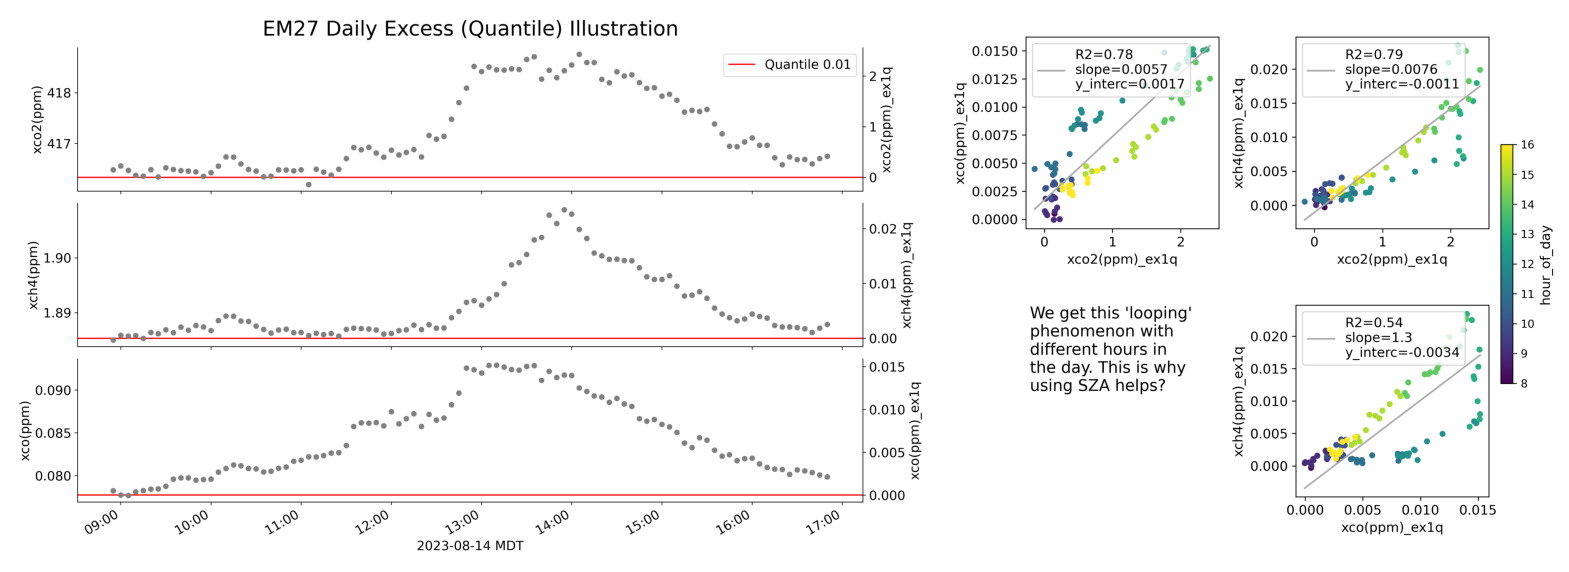

In [99]:
#Display the above plots side by side
fig = plt.figure(figsize = (20,10))
gs = gridspec.GridSpec(1,2,width_ratios=[1.5,1])

ax1 = plt.subplot(gs[0])
ax1.imshow(plt.imread(ts_fname))
ax1.axis('off')

ax2 = plt.subplot(gs[1])
ax2.imshow(plt.imread(ratio_fname))
ax2.axis('off')

plt.subplots_adjust(wspace=0.02)  # Adjust the wspace value as needed

plt.show()

# Compare Methods

## Full WBB Dataset

In [116]:
# Compare methods with full WBB dataset
inst_id = 'ha'

anom_plot_df = all_anom_dfs[inst_id].copy()
skipped_plot_df = all_skipped_dfs[inst_id].copy()
quantile_plot_df = all_quantile_dfs[inst_id].copy()

#below is a quick filter for the extreme outliers found on 2023-08-09, the big spike day. They make the ratio plots look bad...
quantile_plot_df = quantile_plot_df.loc[quantile_plot_df['date']!=datetime.date(2023,8,9)]
anom_plot_df = anom_plot_df.loc[anom_plot_df['date']!=datetime.date(2023,8,9)] 


In [132]:
#Ratio plots for anomaly method

fig,axs = plt.subplots(2,2,figsize = (7,7))
labsize = 10
markersize = 5
fig.suptitle('Anomaly Method',fontsize = 16,y=0.92)
fname = 'em27_allwbb_anomratio.png'

min_sza = anom_plot_df['sza_mid'].min()
max_sza = anom_plot_df['sza_mid'].max()
# Create a ScalarMappable object for color mapping
cmap = 'plasma_r'
norm = Normalize(vmin=min_sza, vmax=max_sza)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # To satisfy ScalarMappable

def single_regression_subplot(ax,plot_df,x_spec,y_spec,markersize,cmap,norm,labsize):
    ax.scatter(plot_df[x_spec],
               plot_df[y_spec],
               c=plot_df['sza_mid'],
               cmap = cmap,
               norm = norm,
               s = markersize)
    reg_details = get_regression(plot_df,x_spec,y_spec)
    plot_reg_on_ax(ax,reg_details,labsize)
    ax.set_xlabel(rmv_prep(x_spec),size = labsize)
    ax.set_ylabel(rmv_prep(y_spec),size = labsize)
    ax.tick_params(labelsize = labsize)
    return ax

ax = axs[0,0]
x_spec = 'corr_xco2(ppm)_anom'
y_spec = 'corr_xco(ppm)_anom'
single_regression_subplot(ax,anom_plot_df,x_spec,y_spec,markersize,cmap,norm,labsize)

ax = axs[0,1]
x_spec = 'corr_xco2(ppm)_anom'
y_spec = 'corr_xch4(ppm)_anom'
single_regression_subplot(ax,anom_plot_df,x_spec,y_spec,markersize,cmap,norm,labsize)

ax = axs[1,1]
x_spec = 'corr_xco(ppm)_anom'
y_spec = 'corr_xch4(ppm)_anom'
single_regression_subplot(ax,anom_plot_df,x_spec,y_spec,markersize,cmap,norm,labsize)

axs[1,0].axis('off')
text = f"DETAILS:\n\
SZA Bin: {sza_bin_size}$^\circ$\n\
Good Anomalies: {len(anom_plot_df)}\n\
No matching SZA: {len(skipped_plot_df.loc[skipped_plot_df['skipmode']=='no_match_sza'])}\n\
Not enough obs: {len(skipped_plot_df.loc[skipped_plot_df['skipmode']=='nobs'])}"
axs[1,0].text(0.02,0.995,text,ha='left',va='top',fontsize = labsize*1.2)

# Creating the colorbar
cbar_ax = fig.add_axes([0.92, 0.3, 0.02, 0.4])  # Adjust position and size of colorbar
cbar = plt.colorbar(sm, cax=cbar_ax)
cbar.set_label('SZA ($^\circ$)', fontsize=labsize)

plt.subplots_adjust(hspace=0.4,wspace = 0.4)
anom_fname = os.path.join(figures_path,fname)
plt.savefig(anom_fname,dpi = 300,bbox_inches = 'tight')
plt.close()
plt.show()


In [133]:
#Ratio plots for quantile method
fig,axs = plt.subplots(2,2,figsize = (7,7))
labsize = 10
markersize = 5
fig.suptitle(f'{quantile} Quantile Excess Method',fontsize = 16,y=0.92)
fname = 'em27_allwbb_quantileratio.png'

colorby_col = 'hour_of_day'
colorby = quantile_plot_df[colorby_col]
cmap = 'viridis'
cmap_min = colorby.min()
cmap_max = colorby.max()
norm = Normalize(vmin=cmap_min, vmax=cmap_max)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # To satisfy ScalarMappable
cbar_ax = fig.add_axes([0.92, 0.3, 0.02, 0.4])  # Adjust position and size of colorbar
cbar = plt.colorbar(sm, cax=cbar_ax)
cbar.set_label(colorby_col, fontsize=labsize)

ax = axs[0,0]
x_spec = quant_col_label('corr_xco2(ppm)',quantile)
y_spec = quant_col_label('corr_xco(ppm)',quantile)
ax.scatter(quantile_plot_df[x_spec],quantile_plot_df[y_spec],c=colorby,cmap=cmap,norm=norm,s = markersize)
reg_details = get_regression(quantile_plot_df,x_spec,y_spec)
plot_reg_on_ax(ax,reg_details,labsize,'darkgrey')
ax.set_xlabel(rmv_prep(x_spec),size = labsize)
ax.set_ylabel(rmv_prep(y_spec),size = labsize)
ax.tick_params(labelsize = labsize)

ax = axs[0,1]
x_spec = quant_col_label('corr_xco2(ppm)',quantile)
y_spec = quant_col_label('corr_xch4(ppm)',quantile)
ax.scatter(quantile_plot_df[x_spec],quantile_plot_df[y_spec],c=colorby,cmap=cmap,norm=norm,s = markersize)
reg_details = get_regression(quantile_plot_df,x_spec,y_spec)
plot_reg_on_ax(ax,reg_details,labsize,'darkgrey')
ax.set_xlabel(rmv_prep(x_spec),size = labsize)
ax.set_ylabel(rmv_prep(y_spec),size = labsize)
ax.tick_params(labelsize = labsize)

ax = axs[1,1]
x_spec = quant_col_label('corr_xco(ppm)',quantile)
y_spec = quant_col_label('corr_xch4(ppm)',quantile)
ax.scatter(quantile_plot_df[x_spec],quantile_plot_df[y_spec],c=colorby,cmap=cmap,norm=norm,s = markersize)
reg_details = get_regression(quantile_plot_df,x_spec,y_spec)
plot_reg_on_ax(ax,reg_details,labsize,'darkgrey')
ax.set_xlabel(rmv_prep(x_spec),size = labsize)
ax.set_ylabel(rmv_prep(y_spec),size = labsize)
ax.tick_params(labelsize = labsize)

axs[1,0].axis('off')
# text = f"We get this 'looping'\n\
# phenomenon with\n\
# different hours in\n\
# the day. This is why\n\
# using SZA helps?"
# axs[1,0].text(0.02,0.995,text,ha='left',va='top',fontsize = labsize*1.2)

plt.subplots_adjust(hspace=0.4,wspace = 0.4)
quant_fname = os.path.join(figures_path,fname)
plt.savefig(quant_fname,dpi = 300,bbox_inches = 'tight')
plt.close()
plt.show()



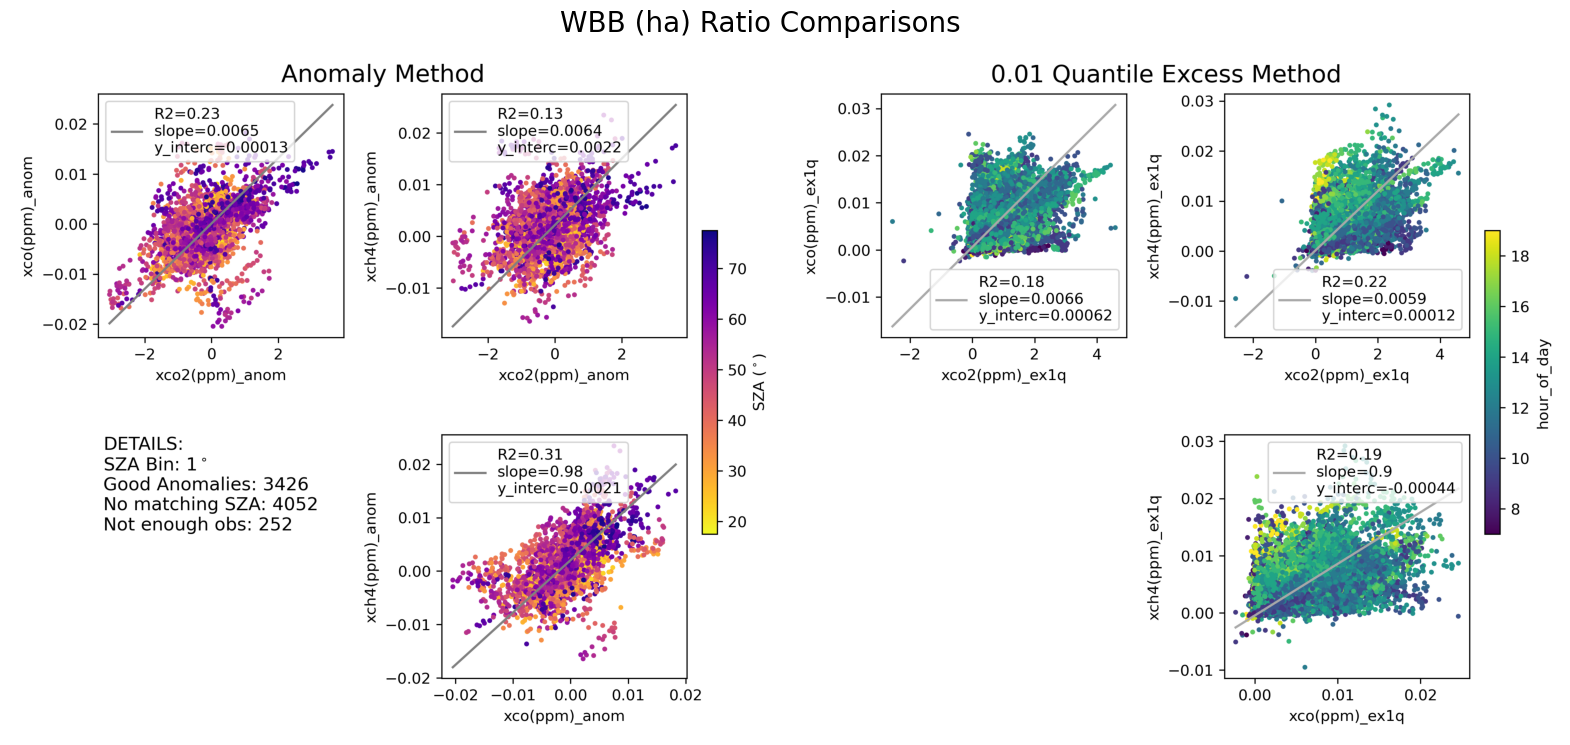

In [134]:
#Display the above plots side by side
fig = plt.figure(figsize = (20,10))
fig.suptitle('WBB (ha) Ratio Comparisons',fontsize = 20,y=0.88)
gs = gridspec.GridSpec(1,2,width_ratios=[1,1])

ax1 = plt.subplot(gs[0])
ax1.imshow(plt.imread(anom_fname))
ax1.axis('off')

ax2 = plt.subplot(gs[1])
ax2.imshow(plt.imread(quant_fname))
ax2.axis('off')

plt.subplots_adjust(wspace=0.02)  # Adjust the wspace value as needed

plt.show()

## Summer 2023 : WBB and DBK

In [130]:
#This compares the WBB to DBK data (from ha and ua, respectively) during times when they were set up across the valley (not side by side)

cross_valley_datestart = datetime.date(2023,7,12) #start date of cross valley collection
cross_valley_dateend = datetime.date(2023,8,12) #end date of cross valley collection
spec_names = ['corr_xco2(ppm)','corr_xch4(ppm)','corr_xco(ppm)']

#Anomaly
summer_anom_dfs = {} #initialize the anomaly and skipped dataframes for each instrument 
summer_skipped_dfs = {}
for inst_id in all_anom_dfs.keys():
    all_anom_df = all_anom_dfs[inst_id]   
    all_skipped_df = all_skipped_dfs[inst_id]
    #filter to the right dates
    all_anom_df = all_anom_df.loc[(all_anom_df['date']>=cross_valley_datestart)&(all_anom_df['date']<=cross_valley_dateend)]
    all_skipped_df = all_skipped_df.loc[(all_skipped_df['date']>=cross_valley_datestart)&(all_skipped_df['date']<=cross_valley_dateend)]
    all_anom_df = all_anom_df.reset_index(drop=True)
    all_skipped_df = all_skipped_df.reset_index(drop = True)
    summer_anom_dfs[inst_id] = all_anom_df
    summer_skipped_dfs[inst_id] = all_skipped_df

#Quantile
summer_quantile_dfs = {} #initialize the quantile and skipped dataframes for each instrument 
for inst_id in all_quantile_dfs.keys():
    all_quantile_df = all_quantile_dfs[inst_id]   
    all_quantile_df = all_quantile_df.loc[(all_quantile_df['date']>=cross_valley_datestart)&(all_quantile_df['date']<=cross_valley_dateend)]
    all_quantile_df = all_quantile_df.reset_index(drop=True)
    summer_quantile_dfs[inst_id] = all_quantile_df

In [142]:
#Make the ratio plots for anomoly method, except this time color by the instrument to compare. Red is ua (DBK), blue is ha (WBB)
fig,axs = plt.subplots(2,2,figsize = (8,8))
labsize = 10
markersize = 5
fig.suptitle('Anomaly Method',fontsize = 16,y=0.92)
fname = 'em27_wbbdbk_anom.png'
colors = {'ua':'red','ha':'blue'}

for inst_id in ['ua','ha']:
    plot_anom_df = summer_anom_dfs[inst_id].copy()
    plot_skipped_df = summer_skipped_dfs[inst_id].copy()
    ax = axs[0,0]
    x_spec = 'corr_xco2(ppm)_anom'
    y_spec = 'corr_xco(ppm)_anom'
    ax.scatter(plot_anom_df[x_spec],plot_anom_df[y_spec],c=colors[inst_id],s = markersize)
    reg_details = get_regression(plot_anom_df,x_spec,y_spec)
    plot_reg_on_ax(ax,reg_details,labsize,colors[inst_id])
    ax.set_xlabel(rmv_prep(x_spec),size = labsize)
    ax.set_ylabel(rmv_prep(y_spec),size = labsize)
    ax.tick_params(labelsize = labsize)

    ax = axs[0,1]
    x_spec = 'corr_xco2(ppm)_anom'
    y_spec = 'corr_xch4(ppm)_anom'
    ax.scatter(plot_anom_df[x_spec],plot_anom_df[y_spec],c=colors[inst_id],s = markersize)
    reg_details = get_regression(plot_anom_df,x_spec,y_spec)
    plot_reg_on_ax(ax,reg_details,labsize,colors[inst_id])
    ax.set_xlabel(rmv_prep(x_spec),size = labsize)
    ax.set_ylabel(rmv_prep(y_spec),size = labsize)
    ax.tick_params(labelsize = labsize)

    ax = axs[1,1]
    x_spec = 'corr_xco(ppm)_anom'
    y_spec = 'corr_xch4(ppm)_anom'
    ax.scatter(plot_anom_df[x_spec],plot_anom_df[y_spec],c=colors[inst_id],s = markersize)
    reg_details = get_regression(plot_anom_df,x_spec,y_spec)
    plot_reg_on_ax(ax,reg_details,labsize,colors[inst_id])
    ax.set_xlabel(rmv_prep(x_spec),size = labsize)
    ax.set_ylabel(rmv_prep(y_spec),size = labsize)
    ax.tick_params(labelsize = labsize)


axs[1,0].axis('off')
text = f"WBB DETAILS:\n\
SZA Bin: {sza_bin_size}$^\circ$\n\
Good Anomalies: {len(summer_anom_dfs['ha'])}\n\
No matching SZA: {len(summer_skipped_dfs['ha'].loc[summer_skipped_dfs['ha']['skipmode']=='no_match_sza'])}\n\
Not enough obs: {len(summer_skipped_dfs['ha'].loc[summer_skipped_dfs['ha']['skipmode']=='nobs'])}"
axs[1,0].text(0.02,0.995,text,ha='left',va='top',fontsize = labsize*1.2,color = 'blue')
text = f"DBK DETAILS:\n\
SZA Bin: {sza_bin_size}$^\circ$\n\
Good Anomalies: {len(summer_anom_dfs['ua'])}\n\
No matching SZA: {len(summer_skipped_dfs['ua'].loc[summer_skipped_dfs['ua']['skipmode']=='no_match_sza'])}\n\
Not enough obs: {len(summer_skipped_dfs['ua'].loc[summer_skipped_dfs['ua']['skipmode']=='nobs'])}"
axs[1,0].text(0.02,0.55,text,ha='left',va='top',fontsize = labsize*1.2,color = 'red')

plt.subplots_adjust(hspace=0.4,wspace = 0.4)
anom_fname = os.path.join(figures_path,fname)
plt.savefig(anom_fname,dpi=300,bbox_inches = 'tight')
plt.close()
plt.show()


In [143]:
#Make the quantile ratio plots, except this time color by the instrument to compare. Red is ua (DBK), blue is ha (WBB)

fig,axs = plt.subplots(2,2,figsize = (8,8))
labsize = 10
markersize = 5
fig.suptitle(f'{quantile} Quantile Excess Method',fontsize = 16,y = 0.92)
fname = 'em27_wbbdbk_quantil.png'
colors = {'ua':'red','ha':'blue'}

for inst_id in ['ua','ha']:
    plot_quantile_df = summer_quantile_dfs[inst_id].copy()
    ax = axs[0,0]
    x_spec = quant_col_label('corr_xco2(ppm)',quantile)
    y_spec = quant_col_label('corr_xco(ppm)',quantile)
    ax.scatter(plot_quantile_df[x_spec],plot_quantile_df[y_spec],c=colors[inst_id],s = markersize)
    reg_details = get_regression(plot_quantile_df,x_spec,y_spec)
    plot_reg_on_ax(ax,reg_details,labsize,colors[inst_id])
    ax.set_xlabel(rmv_prep(x_spec),size = labsize)
    ax.set_ylabel(rmv_prep(y_spec),size = labsize)
    ax.tick_params(labelsize = labsize)

    ax = axs[0,1]
    x_spec = quant_col_label('corr_xco2(ppm)',quantile)
    y_spec = quant_col_label('corr_xch4(ppm)',quantile)
    ax.scatter(plot_quantile_df[x_spec],plot_quantile_df[y_spec],c=colors[inst_id],s = markersize)
    reg_details = get_regression(plot_quantile_df,x_spec,y_spec)
    plot_reg_on_ax(ax,reg_details,labsize,colors[inst_id])
    ax.set_xlabel(rmv_prep(x_spec),size = labsize)
    ax.set_ylabel(rmv_prep(y_spec),size = labsize)
    ax.tick_params(labelsize = labsize)

    ax = axs[1,1]
    x_spec = quant_col_label('corr_xco(ppm)',quantile)
    y_spec = quant_col_label('corr_xch4(ppm)',quantile)
    ax.scatter(plot_quantile_df[x_spec],plot_quantile_df[y_spec],c=colors[inst_id],s = markersize)
    reg_details = get_regression(plot_quantile_df,x_spec,y_spec)
    plot_reg_on_ax(ax,reg_details,labsize,colors[inst_id])
    ax.set_xlabel(rmv_prep(x_spec),size = labsize)
    ax.set_ylabel(rmv_prep(y_spec),size = labsize)
    ax.tick_params(labelsize = labsize)


axs[1,0].axis('off')
# text = f"WBB DETAILS:\n\
# SZA Bin: {sza_bin_size}$^\circ$\n\
# Good Anomalies: {len(summer_anom_dfs['ha'])}\n\
# No matching SZA: {len(summer_skipped_dfs['ha'].loc[summer_skipped_dfs['ha']['skipmode']=='no_match_sza'])}\n\
# Not enough obs: {len(summer_skipped_dfs['ha'].loc[summer_skipped_dfs['ha']['skipmode']=='nobs'])}"
# axs[1,0].text(0.02,0.995,text,ha='left',va='top',fontsize = labsize*1.2,color = 'blue')
# text = f"DBK DETAILS:\n\
# SZA Bin: {sza_bin_size}$^\circ$\n\
# Good Anomalies: {len(summer_anom_dfs['ua'])}\n\
# No matching SZA: {len(summer_skipped_dfs['ua'].loc[summer_skipped_dfs['ua']['skipmode']=='no_match_sza'])}\n\
# Not enough obs: {len(summer_skipped_dfs['ua'].loc[summer_skipped_dfs['ua']['skipmode']=='nobs'])}"
# axs[1,0].text(0.02,0.55,text,ha='left',va='top',fontsize = labsize*1.2,color = 'red')

plt.subplots_adjust(hspace=0.4,wspace = 0.4)
quant_fname = os.path.join(figures_path,fname)
plt.savefig(quant_fname,dpi=300,bbox_inches = 'tight')
plt.close()
plt.show()


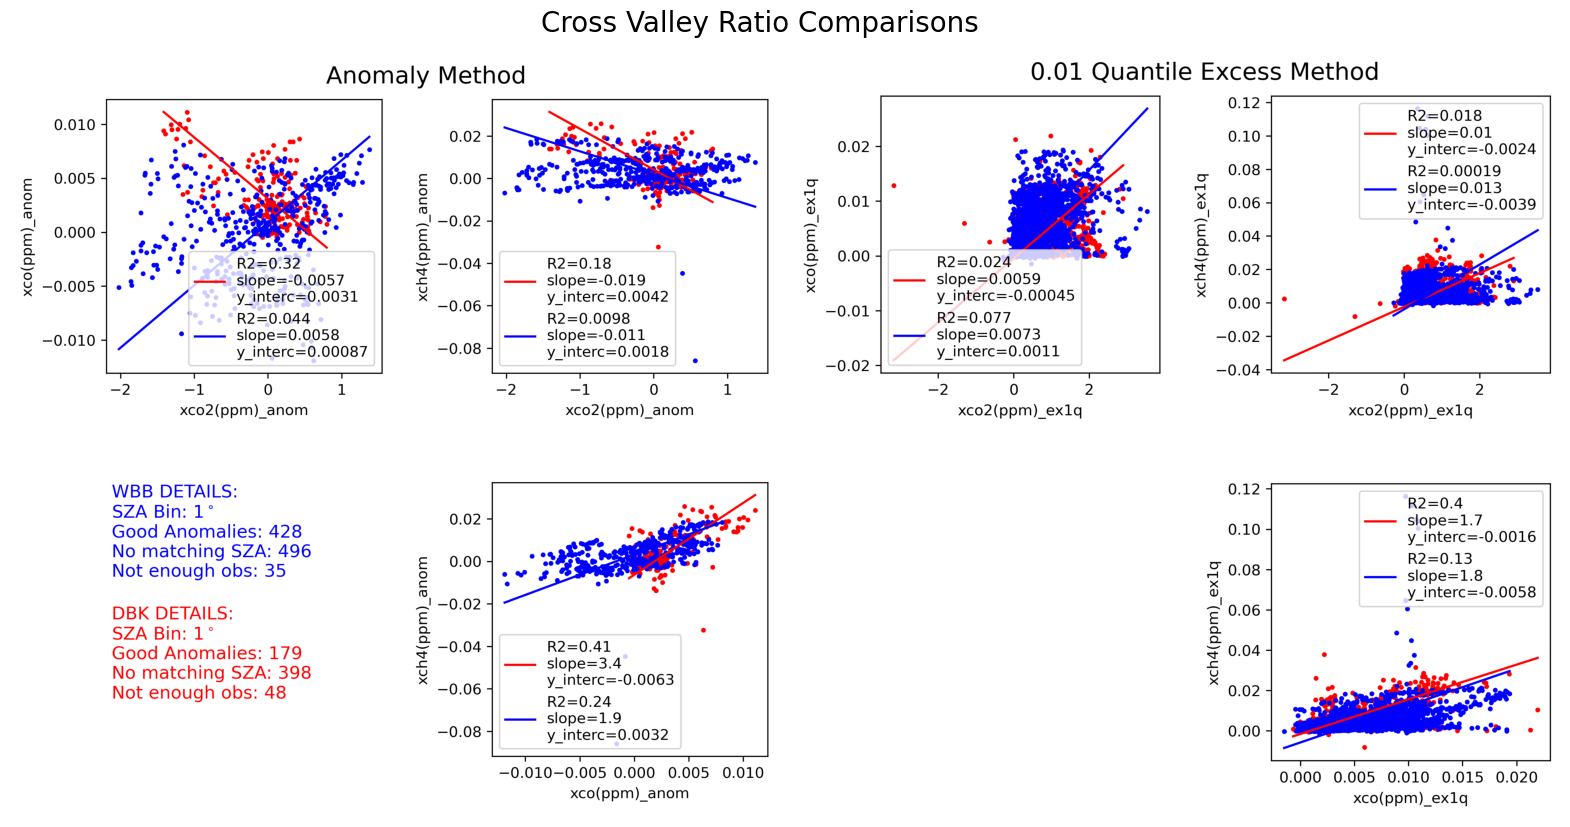

In [146]:
#Display the above plots side by side
fig = plt.figure(figsize = (20,10))
fig.suptitle('Cross Valley Ratio Comparisons',fontsize = 20,y=0.92)
gs = gridspec.GridSpec(1,2,width_ratios=[1,1])

ax1 = plt.subplot(gs[0])
ax1.imshow(plt.imread(anom_fname))
ax1.axis('off')

ax2 = plt.subplot(gs[1])
ax2.imshow(plt.imread(quant_fname))
ax2.axis('off')

plt.subplots_adjust(wspace=0.02)  # Adjust the wspace value as needed

plt.show()

## Day By Day

In [147]:
#T his allows us to look at the anomaly ratios per day. Instead of plotting all of the anomalies on a single plot,
# it allows us to look at the daily anomaly ratios and examine how they change, and how the correlations get better or worse. 

daily_anom_summary_dfs = {} #initialize the daily anomoly summary dataframes (one for each instrument will be created)

for inst_id,all_anom_df in all_anom_dfs.items(): #loop through the anomaly dataframes for each instrument
    daily_anom_summary_list = [] #this is the daily summary list for that instrument we will use to build the dataframe
    for date, day_anom_df in all_anom_df.groupby('date'): # go through each dau
        if len(day_anom_df)<5: #if there are fewer than 5 good anomalies, skip that day. 
            continue
        daily_anom_summary_dict = dict(date = date,
                                    good_anoms = len(day_anom_df)) #log the good anomalies
        
        #Run the regressions for each covarying species of interest, on that specific day, and log dthe results
        reg_details = get_regression(day_anom_df,'corr_xco2(ppm)_anom','corr_xco(ppm)_anom') 
        daily_anom_summary_dict.update(dict(xco_xco2_slope = reg_details['slope'],
                                            xco_xco2_yint = reg_details['yint'],
                                            xco_xco2_r2 = reg_details['r2']))
        
        reg_details = get_regression(day_anom_df,'corr_xco2(ppm)_anom','corr_xch4(ppm)_anom')
        daily_anom_summary_dict.update(dict(xch4_xco2_slope = reg_details['slope'],
                                            xch4_xco2_yint = reg_details['yint'],
                                            xch4_xco2_r2 = reg_details['r2']))
        
        reg_details = get_regression(day_anom_df,'corr_xco(ppm)_anom','corr_xch4(ppm)_anom')
        daily_anom_summary_dict.update(dict(xch4_xco_slope = reg_details['slope'],
                                            xch4_xco_yint = reg_details['yint'],
                                            xch4_xco_r2 = reg_details['r2']))
        
        daily_anom_summary_list.append(daily_anom_summary_dict) #append the regression results to the list
        
    daily_anom_summary_df = pd.DataFrame(daily_anom_summary_list) #create the summary dataframe from the list
    daily_anom_summary_dfs[inst_id] = daily_anom_summary_df #add them to the instrument


#T his allows us to look at the anomaly ratios per day. Instead of plotting all of the anomalies on a single plot,
# it allows us to look at the daily anomaly ratios and examine how they change, and how the correlations get better or worse. 

daily_quantile_summary_dfs = {} #initialize the daily anomoly summary dataframes (one for each instrument will be created)

for inst_id,all_quantile_df in all_quantile_dfs.items(): #loop through the anomaly dataframes for each instrument
    daily_quantile_summary_list = [] #this is the daily summary list for that instrument we will use to build the dataframe
    for date, day_quantile_df in all_quantile_df.groupby('date'): # go through each dau
        if len(day_quantile_df)<10: #if there are fewer than 5 good anomalies, skip that day. 
            continue
        daily_quantile_summary_dict = dict(date = date,
                                    obs = len(day_quantile_df)) #log the good anomalies
        
        #Run the regressions for each covarying species of interest, on that specific day, and log dthe results
        reg_details = get_regression(day_quantile_df,quant_col_label('corr_xco2(ppm)',quantile),quant_col_label('corr_xco(ppm)',quantile)) 
        daily_quantile_summary_dict.update(dict(xco_xco2_slope = reg_details['slope'],
                                            xco_xco2_yint = reg_details['yint'],
                                            xco_xco2_r2 = reg_details['r2']))
        
        reg_details = get_regression(day_quantile_df,quant_col_label('corr_xco2(ppm)',quantile),quant_col_label('corr_xch4(ppm)',quantile)) 
        daily_quantile_summary_dict.update(dict(xch4_xco2_slope = reg_details['slope'],
                                            xch4_xco2_yint = reg_details['yint'],
                                            xch4_xco2_r2 = reg_details['r2']))
        
        reg_details = get_regression(day_quantile_df,quant_col_label('corr_xco(ppm)',quantile),quant_col_label('corr_xch4(ppm)',quantile)) 
        daily_quantile_summary_dict.update(dict(xch4_xco_slope = reg_details['slope'],
                                            xch4_xco_yint = reg_details['yint'],
                                            xch4_xco_r2 = reg_details['r2']))
        
        daily_quantile_summary_list.append(daily_quantile_summary_dict) #append the regression results to the list
        
    daily_quantile_summary_df = pd.DataFrame(daily_quantile_summary_list) #create the summary dataframe from the list
    daily_quantile_summary_dfs[inst_id] = daily_quantile_summary_df #add them to the instrument

In [148]:
# Look at the daily anomaly ratios as a timeseries, colored by the r2 values

inst_id = 'ha'
daily_anom_summary_df = daily_anom_summary_dfs[inst_id]

fig = make_subplots(3,1,shared_xaxes=True)
fig.add_trace(go.Scatter(
    x = daily_anom_summary_df['date'],
    y = daily_anom_summary_df['xco_xco2_slope'],
    customdata=np.stack((daily_anom_summary_df['good_anoms'],daily_anom_summary_df['xco_xco2_r2']), axis=-1),
    mode = 'markers',
    marker = dict(color = daily_anom_summary_df['xco_xco2_r2'],
                cmax = 1,
                cmin = 0),
    hovertemplate = #sets up the hover data
    "date = %{x}<br>" +
    "ratio_slope = %{y}<br>" +
    "num anoms = %{customdata[0]}<br>" + #bold and include the z information
    "r2 = %{customdata[1]:.2f}<br>" ,
),row = 1,col = 1)
fig.update_yaxes(title_text='CO_to_CO2_slope', row=1, col=1)

fig.add_trace(go.Scatter(
    x = daily_anom_summary_df['date'],
    y = daily_anom_summary_df['xch4_xco2_slope'],
    customdata=np.stack((daily_anom_summary_df['good_anoms'],daily_anom_summary_df['xch4_xco2_r2']), axis=-1),
    mode = 'markers',
    marker = dict(color = daily_anom_summary_df['xch4_xco2_r2'],
                cmax = 1,
                cmin = 0),
    hovertemplate = #sets up the hover data
    "date = %{x}<br>" +
    "ratio_slope = %{y}<br>" +
    "num anoms = %{customdata[0]}<br>" + #bold and include the z information
    "r2 = %{customdata[1]:.2f}<br>" ,
),row = 2,col = 1)
fig.update_yaxes(title_text='CH4_to_CO2_slope', row=2, col=1)

fig.add_trace(go.Scatter(
    x = daily_anom_summary_df['date'],
    y = daily_anom_summary_df['xch4_xco_slope'],
    customdata=np.stack((daily_anom_summary_df['good_anoms'],daily_anom_summary_df['xch4_xco_r2']), axis=-1),
    mode = 'markers',
    # marker_color = daily_anom_summary_df['xch4_xco_r2'],
    marker = dict(color = daily_anom_summary_df['xch4_xco_r2'],
                  cmax = 1,
                  cmin = 0,
                  colorbar = dict(title='R2')),
    hovertemplate = #sets up the hover data
    "date = %{x}<br>" +
    "ratio_slope = %{y}<br>" +
    "num anoms = %{customdata[0]}<br>" + #bold and include the z information
    "r2 = %{customdata[1]:.2f}<br>" ,
),row = 3,col = 1)
fig.update_yaxes(title_text='CH4_to_CO_slope', row=3, col=1)

fig.update_layout(
    height = 700,
    showlegend = False
)

In [150]:
# Look at the daily quantile ratios as a timeseries, colored by the r2 values

inst_id = 'ha'
daily_quantile_summary_df = daily_quantile_summary_dfs[inst_id]

fig = make_subplots(3,1,shared_xaxes=True)
fig.add_trace(go.Scatter(
    x = daily_quantile_summary_df['date'],
    y = daily_quantile_summary_df['xco_xco2_slope'],
    customdata=np.stack((daily_quantile_summary_df['obs'],daily_quantile_summary_df['xco_xco2_r2']), axis=-1),
    mode = 'markers',
    marker = dict(color = daily_quantile_summary_df['xco_xco2_r2'],
                cmax = 1,
                cmin = 0),
    hovertemplate = #sets up the hover data
    "date = %{x}<br>" +
    "ratio_slope = %{y}<br>" +
    "num obs = %{customdata[0]}<br>" + #bold and include the z information
    "r2 = %{customdata[1]:.2f}<br>" ,
),row = 1,col = 1)
fig.update_yaxes(title_text='CO_to_CO2_slope', row=1, col=1)

fig.add_trace(go.Scatter(
    x = daily_quantile_summary_df['date'],
    y = daily_quantile_summary_df['xch4_xco2_slope'],
    customdata=np.stack((daily_quantile_summary_df['obs'],daily_quantile_summary_df['xch4_xco2_r2']), axis=-1),
    mode = 'markers',
    marker = dict(color = daily_quantile_summary_df['xch4_xco2_r2'],
                cmax = 1,
                cmin = 0),
    hovertemplate = #sets up the hover data
    "date = %{x}<br>" +
    "ratio_slope = %{y}<br>" +
    "num obs = %{customdata[0]}<br>" + #bold and include the z information
    "r2 = %{customdata[1]:.2f}<br>" ,
),row = 2,col = 1)
fig.update_yaxes(title_text='CH4_to_CO2_slope', row=2, col=1)

fig.add_trace(go.Scatter(
    x = daily_quantile_summary_df['date'],
    y = daily_quantile_summary_df['xch4_xco_slope'],
    customdata=np.stack((daily_quantile_summary_df['obs'],daily_quantile_summary_df['xch4_xco_r2']), axis=-1),
    mode = 'markers',
    # marker_color = daily_quantile_summary_df['xch4_xco_r2'],
    marker = dict(color = daily_quantile_summary_df['xch4_xco_r2'],
                  cmax = 1,
                  cmin = 0,
                  colorbar = dict(title='R2')),
    hovertemplate = #sets up the hover data
    "date = %{x}<br>" +
    "ratio_slope = %{y}<br>" +
    "num obs = %{customdata[0]}<br>" + #bold and include the z information
    "r2 = %{customdata[1]:.2f}<br>" ,
),row = 3,col = 1)
fig.update_yaxes(title_text='CH4_to_CO_slope', row=3, col=1)

fig.update_layout(
    height = 700,
    showlegend = False
)